# Machine Learning Approach for Detection of Cyber Bullying and Cyber Aggressive Comments using Paragraph Vectors as features from Doc2Vec 


By:
Dr. Shylaja S S (Chairperson,Dept of CSE, PES University,Prof & Head of the Dept CS & IS,PESIT,Bangalore), Abhishek Narayanan, Abhijith Venugopal and Abhishek Prasad,
Department of Computer Science and Engineering,
PES University, Bangalore, India


## Setup

### Modules

Import `gensim`, which provides extremely readable implementations of Doc2Vec for generating document embeddings or paragraph vectors which we use as the feature matrix to train our models. The classification algorithms used in the models include the implementations of sklearn for machine learning classifiers.

In [1]:
from __future__ import print_function

#numpy
import numpy as np

#Time
import time

#Graphing Tools
import pandas as pd
import itertools
import matplotlib.pyplot as plt

#Gensim modules
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from random import shuffle

#Classifiers and Evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPClassifier
import sklearn.metrics as metrics




Using TensorFlow backend.
/home/abhishek/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Input Format


We use four documents for training and testing purposes which are described below:

- `Train_CyberBullying_Dataset.csv`: 5317 Cyber Agressive Comments as Training Data
- `Train_NonCyberBullying_Dataset.csv`: 15328 Non Cyber Agressive Comments as Training Data
- `Test_CyberBullying_Dataset.csv`: 2505 Cyber Agressive Comments as Training Data
- `Test_NonCyberBullying_Dataset.csv`: 6312 Non Cyber Agressive Comments as Training Data

The data contained in these Files have been collected from Kaggle and other sources and have been segregated according to their labels. The total data was split into 20845 training data and 8817 testing data which were further split into CyberBullying and Non CyberBullying categories into their respective files.

Each of the files should be formatted as such:

```
Nope. I know a little thai and some spanish. haha go figure.Im seriously the whitest korean chick you'd ever meet :]
Idk I think it swings both ways pretty strongly. The human race is never satisfied and I believe that both sexes have    
the tendencey to cheat. At all ages and for all reasons.
Timmy. He held me down and tickled me
im not the one who called you a whore either haha. i play soccer and run track and did dance for eight years and did      
gymnastics
What would a chair look like if your knees bent the other way?
formspringg haha noo..my boyfriend. Were always out staying busy.
Would you rather be rich or famous?
crude?
Haha youu need a phone !(:
you should ask her if shes still 
r Has anybody ever told you that!

```

The sample up there contains 10 non cyber aggressive comments, each one taking up one entire line. Yes, **each comment should be on one line, separated by new lines**. This is extremely important, because our parser depends on this to identify sentences.

### Feeding Input Text Data to Doc2Vec for training and generation of document embeddings


The sentences are tokenized and each set of tokens is associated with a paragraph id or tag before training, indicating the document type the sentence comes from. For convenience in our experimentation, we generatethe document ids with respect to the files the comments come from, because of which the training and testing data is split into a pair of files each containing cyber-aggressive and non cyber-aggressive comments. The tags are then conveniently generated with a prefix indicating whether the data is from training or testing dataset and whether
it is cyber-aggressive or non cyber-aggressive. This prefix is coupled with a unique index for each comment for uniqueness and to facilitate retrieval of vectors after training.

In [2]:
class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    

In [3]:
sources = {'Train_CyberBullying_Dataset.csv':'TRAIN_CB', 'Train_NotCyberBullying_Dataset.csv':'TRAIN_NCB','Test_CyberBullying_Dataset.csv':'TEST_CB', 'Test_NotCyberBullying_Dataset.csv':'TEST_NCB'}

sentences = LabeledLineSentence(sources)

## Model
This aggregation of tagged tokenized comments from training and testing pairs of datasets are shuffled randomly for
better training and eliminating any dependency on the order of feeding the input, are then fed to the Doc2Vec model for training. The training has been performed for 10 epochs in order to obtain better results. Typically 10 epochs
is found to be sufficiently suitable for generating favourable features and therefore our experimentation includes this parameter as such. After training is performed, we extract the feature vectors for training and testing data into separate arrays with their corresponding labels in separate arrays, for being fed to machine learning algorithms for classification. The number of dimensions of the dense feature vectors has been chosen to be 100, found to be optimum.learning algorithms. Since the training arrays are arranged such that the cyber-aggressive and non cyber-aggressive comments are grouped together, we shuffle the arrays randomly to ensure that the models remain independent of the feeding order of the input vectors.

In [6]:

model = Doc2Vec(min_count=1, window=10, size=100, sample=1e-4, negative=5, workers=7)

model.build_vocab(sentences.to_array())

sentences_list=sentences.to_array()

#Creating Permutations of Training Data for effective Training of the model

Idx=list(range(len(sentences_list)))

for epoch in range(10):
  shuffle(Idx)
  perm_sentences = [sentences_list[i] for i in Idx]
  model.train(perm_sentences,total_examples=model.corpus_count,epochs=model.iter)

Here's a sample vector for the first sentence in the training set for Cyber Bullying Comments:

In [6]:
model.docvecs['TRAIN_CB_0']

array([-0.00831292,  0.09825369, -0.04923785,  0.05114977,  0.00372908,
       -0.03397796,  0.03419921, -0.00203457,  0.00052569,  0.00239598,
       -0.05035845, -0.03942598, -0.02747261, -0.04080142,  0.00211238,
        0.02096845, -0.1031188 ,  0.08303852,  0.02917217, -0.01683435,
       -0.02226654, -0.0513053 , -0.05152449, -0.0482181 , -0.09313622,
        0.02926778,  0.03669933,  0.04154068,  0.00189697,  0.00625398,
       -0.10623635,  0.05894942, -0.10154229,  0.01880607,  0.04673703,
        0.00970345,  0.01688087,  0.07221666, -0.04007239, -0.01134455,
        0.03825495,  0.04632282,  0.06648249,  0.00019437,  0.17043862,
        0.05011575, -0.02811001,  0.02281089, -0.00415329, -0.01837475,
        0.04688167, -0.04075466,  0.0015317 ,  0.04531683, -0.10790066,
        0.06248958,  0.06867082,  0.05831517, -0.10885508,  0.04679925,
       -0.08376778,  0.09897499,  0.02925679,  0.0378907 ,  0.0142093 ,
        0.01442247,  0.01984593, -0.05650358,  0.055339  ,  0.00

### Saving and Loading Models

To avoid training the model again, we can save it.

In [7]:
model.save('./cb.d2v')

And load it.

In [8]:
model = Doc2Vec.load('./cb.d2v')

## Classifying Comments

### Training Vectors

Now let's use these vectors to train a classifier. First, we must extract the training vectors. Remember that we have a total of 20645 training reviews, with 5317 Cyber aggressive comments and 15328 Non Cyber aggressive comments.

We simply put the aggressive ones at the first half of the array, and the non aggressive ones at the second half.

In [7]:
train_arrays = np.zeros((20645, 100))
train_labels = np.zeros(20645)

for i in range(5317):
        prefix_train_CB = 'TRAIN_CB_' + str(i)
        train_arrays[i] = model.docvecs[prefix_train_CB]
        train_labels[i] = 1
for i in range(15328):
        prefix_train_NCB = 'TRAIN_NCB_' + str(i)
        train_arrays[5317+i] = model.docvecs[prefix_train_NCB]
        train_labels[5317 + i] = 0
   

The training array looks like this: rows and rows of vectors representing each sentence.

In [10]:
print(train_arrays)

[[-0.00831292  0.09825369 -0.04923785 ...,  0.04261166 -0.02553433
  -0.12763123]
 [ 0.03902274  0.04047017  0.14389972 ..., -0.158887   -0.25084406
  -0.04280652]
 [-0.04801754  0.28612185 -0.05625761 ...,  0.09778229  0.04505434
  -0.25631768]
 ..., 
 [-0.05437396  0.20120709  0.04630677 ...,  0.12280104  0.1764188
  -0.02732237]
 [-0.0533185   0.16336858 -0.11481324 ...,  0.06998151 -0.05352958
  -0.16787659]
 [ 0.05927484 -0.02124818  0.07755839 ...,  0.10260783  0.03164626
  -0.18994899]]


The labels are simply category labels for the sentence vectors -- 1 representing positive and 0 for negative.

In [11]:
print(train_labels)

[ 1.  1.  1. ...,  0.  0.  0.]


### Testing Vectors

We do the same for testing data -- data that we are going to feed to the classifier after we've trained it using the training data. This allows us to evaluate our results. The process is pretty much the same as extracting the results for the training data.

In [8]:
test_arrays = np.zeros((8817, 100))
test_labels = np.zeros(8817)

for i in range(2505):
    prefix_test_CB = 'TEST_CB_' + str(i)
    test_arrays[i] = model.docvecs[prefix_test_CB]
    test_labels[i] = 1
for i in range(6312):
    prefix_test_NCB = 'TEST_NCB_' + str(i)
    test_arrays[2505 + i] = model.docvecs[prefix_test_NCB]
    test_labels[2505 + i] = 0
    

### Classification

Now we train the different classifiers using the training data.Prediction accuracy and time taken by each is calculated.

In [9]:
#KNN
start=time.time()
K_value = 1
clf_knn = KNeighborsClassifier(n_neighbors = K_value, weights='uniform', algorithm='auto')
clf_knn.fit(train_arrays, train_labels) 
y_pred_knn = clf_knn.predict(test_arrays)
end=time.time()
print("Accuracy is ", accuracy_score(test_labels,y_pred_knn)*100,"% for K-Value:",K_value,"Time taken:",(end-start))


#Logistic Regression
start=time.time()
clf_logistic = LogisticRegression()
clf_logistic.fit(train_arrays, train_labels)
y_pred_logistic=clf_logistic.predict(test_arrays)
end=time.time()
print("Accuracy is ", accuracy_score(test_labels,y_pred_logistic)*100,"% for Logistic regression","Time taken:",(end-start))


#Support Vector Machine
s=['linear', 'poly', 'rbf']
for kernel in s:
    start=time.time()
    clf_svm = svm.SVC(kernel=kernel, gamma=2)
    clf_svm.fit(train_arrays, train_labels)
    y_pred_svm=clf_svm.predict(test_arrays)
    end=time.time()
    print( "Accuracy is ",accuracy_score(test_labels,y_pred_svm)*100,"% for SVM with kernel = ",kernel,"Time taken:",(end-start))
clf_svm = svm.SVC(kernel='rbf', gamma=2)

#Random forest classifier
start=time.time()
from sklearn.ensemble import RandomForestClassifier
clf_forest = RandomForestClassifier(n_estimators=20)
clf_forest.fit(train_arrays,train_labels)
y_pred_forest = clf_forest.predict(test_arrays)
end=time.time()
print( "Accuracy is ", accuracy_score(test_labels,y_pred_forest)*100,"% for Random Forest Classifier","Time taken:",(end-start))


#Bernoulli Naive Bayes
start=time.time()
from sklearn.naive_bayes import BernoulliNB
clf_Ber = BernoulliNB()
clf_Ber.fit(train_arrays,train_labels)
y_pred_Ber = clf_Ber.predict(test_arrays)
end=time.time()
print("Accuracy is ",accuracy_score(test_labels, y_pred_Ber)*100,"% for Bernoulli Naive Bayes","Time taken:",(end-start))


#Decision Tree
start=time.time()
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth=3, min_samples_leaf=5)
clf_gini.fit(train_arrays,train_labels)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')
y_pred_tree = clf_gini.predict(test_arrays)
end=time.time()
print("Accuracy is ", accuracy_score(test_labels,y_pred_tree)*100,"% for Decision Tree","Time taken:",(end-start))




Accuracy is  98.7977770217 % for K-Value: 1 Time taken: 51.37172055244446
Accuracy is  70.6362708404 % for Logistic regression Time taken: 1.191629409790039
Accuracy is  71.5889758421 % for SVM with kernel =  linear Time taken: 89.38022017478943
Accuracy is  86.276511285 % for SVM with kernel =  poly Time taken: 480.3562819957733
Accuracy is  88.2159464671 % for SVM with kernel =  rbf Time taken: 379.2435071468353
Accuracy is  82.2728819326 % for Random Forest Classifier Time taken: 7.1180431842803955
Accuracy is  62.6063286832 % for Bernoulli Naive Bayes Time taken: 0.1239631175994873
Accuracy is  71.5889758421 % for Decision Tree Time taken: 1.8877980709075928


And find that we have achieved approximately 98% accuracy in classifying text as Cyber Aggressive and Non Cyber Aggressive. This is rather incredible, given that we are only using KNN and a very shallow neural network.

## Comparison of Accuracies of other Machine Learning Algorithms for detection of Cyber Bullying

Accuracy is  98.7977770217 % for K-Value: 1 Time taken: 51.37172055244446
Accuracy is  70.6362708404 % for Logistic regression Time taken: 1.191629409790039
Accuracy is  71.5889758421 % for SVM with kernel =  linear Time taken: 89.38022017478943
Accuracy is  86.276511285 % for SVM with kernel =  poly Time taken: 480.3562819957733
Accuracy is  88.2159464671 % for SVM with kernel =  rbf Time taken: 379.2435071468353
Accuracy is  82.2728819326 % for Random Forest Classifier Time taken: 7.1180431842803955
Accuracy is  62.6063286832 % for Bernoulli Naive Bayes Time taken: 0.1239631175994873
Accuracy is  71.5889758421 % for Decision Tree Time taken: 1.8877980709075928


## Evaluation Metrics 

### Plotting the Confusion Matrix for Evaluation of the Models 

Confusion Matrices can be used to visualize and evaluate the Results given by the Models we use. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.
The figures show the confusion matrix with and without normalization by class support size (number of elements in each class). This kind of normalization can be interesting in case of class imbalance to have a more visual interpretation of which class is being misclassified.

Confusion matrix, without normalization
[[6250   62]
 [  44 2461]]


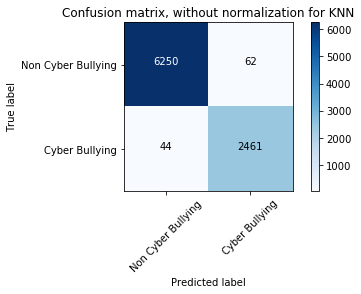

Confusion matrix, without normalization
[[6080  232]
 [2357  148]]


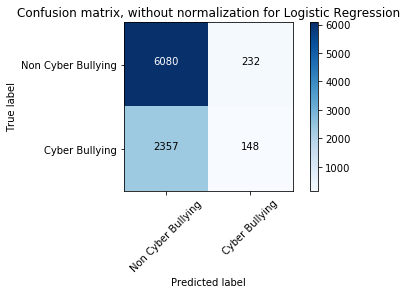

Confusion matrix, without normalization
[[6268   44]
 [ 995 1510]]


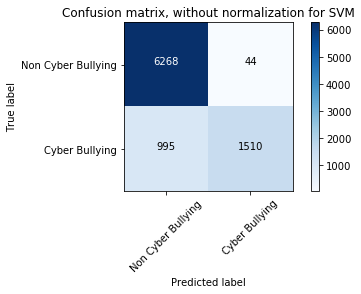

Confusion matrix, without normalization
[[4620 1692]
 [1605  900]]


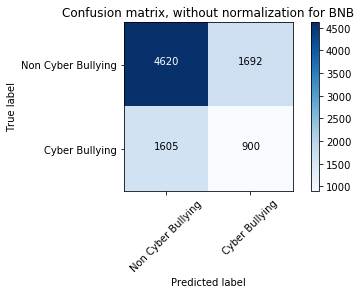

Confusion matrix, without normalization
[[6312    0]
 [2505    0]]


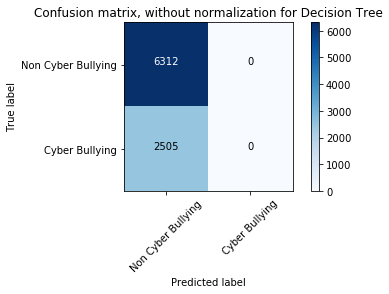

Confusion matrix, without normalization
[[6239   73]
 [1490 1015]]


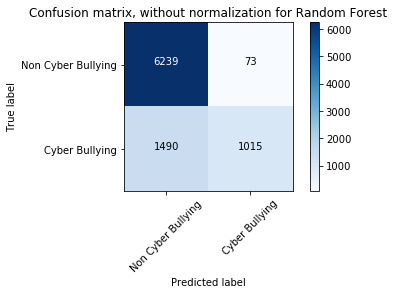

----------------------------------------------------------------------------------------------------------------
Cross Validation Scores and standard deviation for each :-
Logistic Regression: 0.725864 (0.402335)
KNN: 0.898565 (0.065481)
Random Forest: 0.764106 (0.344023)
Decision Tree: 0.741037 (0.429018)
Bernouli Navie Byes: 0.634910 (0.208590)


In [17]:
class_names=['Non Cyber Bullying','Cyber Bullying']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    #This function prints and plots the confusion matrix.Normalization can be applied by setting `normalize=True`.
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#KNN
# Compute confusion matrix for KNN
cnf_matrix = confusion_matrix(test_labels, y_pred_knn)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization for KNN')

plt.show()


#Logistic Regression
# Compute confusion matrix for Logistic Regression
cnf_matrix = confusion_matrix(test_labels, y_pred_logistic)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization for Logistic Regression')
plt.show()


#Support Vector Machine
# Compute confusion matrix for SVM
cnf_matrix = confusion_matrix(test_labels, y_pred_svm)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization for SVM')
plt.show()


#Bernoulli Naive Bayes
# Compute confusion matrix for GNB
cnf_matrix = confusion_matrix(test_labels, y_pred_Ber)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization for BNB')

plt.show()

#Decision Tree
# Compute confusion matrix for Decision Tree
cnf_matrix = confusion_matrix(test_labels, y_pred_tree)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization for Decision Tree')

plt.show()

#Random forest classifier
cnf_matrix = confusion_matrix(test_labels, y_pred_forest)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization for Random Forest')

plt.show()

### K-fold Cross Validation
print("----------------------------------------------------------------------------------------------------------------")
print("Cross Validation Scores and standard deviation for each :-")
##Comparison graphs
from sklearn import model_selection
X = train_arrays
y = train_labels
# prepare configuration for cross validation test harness
seed = 7
models = []
models.append(('Logistic Regression',clf_logistic ))
models.append(('KNN', clf_knn))
models.append(('Random Forest', clf_forest))
models.append(('Decision Tree', clf_gini))
models.append(('Bernouli Navie Byes', clf_Ber))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=20, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
#fig = plt.figure()
#fig.suptitle('Algorithm Comparison')
#ax = fig.add_subplot(111)
#plt.boxplot(results)
#ax.set_xticklabels(names)
#plt.show()


###  Plotting the Reciever Operating Characteristic Curve and obtaining the area under the ROC Curve 

In statistics, a receiver operating characteristic curve, i.e. ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity, recall or probability of detection[1] in machine learning. The false-positive rate is also known as the fall-out or probability of false alarm[1] and can be calculated as (1 − specificity). The ROC curve is thus the sensitivity as a function of fall-out. In general, if the probability distributions for both detection and false alarm are known, the ROC curve can be generated by plotting the cumulative distribution function (area under the probability distribution from {\displaystyle -\infty } -\infty  to the discrimination threshold) of the detection probability in the y-axis versus the cumulative distribution function of the false-alarm probability on the x-axis.

 Accuracy is measured by the area under the ROC curve. An area of 1 represents a perfect test; an area of .5 represents a worthless test.

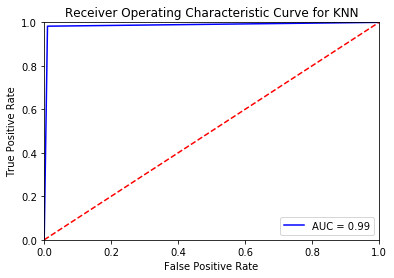

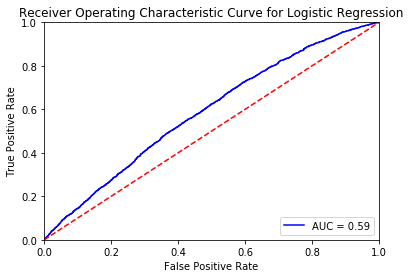

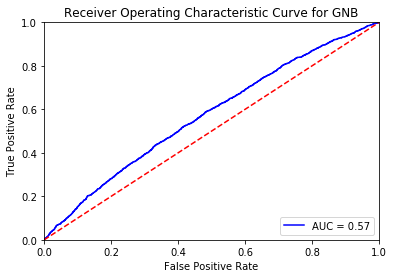

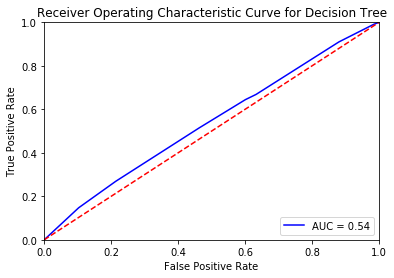

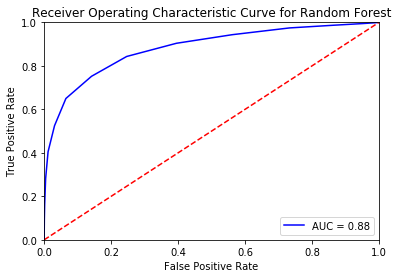

In [18]:
# Calculate the fpr and tpr for all thresholds of the classification

#KNN
probs = clf_knn.predict_proba(test_arrays)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_labels, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic Curve for KNN')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Logistic Regression
probs = clf_logistic.predict_proba(test_arrays)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_labels, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic Curve for Logistic Regression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



#Bernoulli Naive Bayes
probs = clf_Ber.predict_proba(test_arrays)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_labels, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic Curve for GNB')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Decision Tree
probs = clf_gini.predict_proba(test_arrays)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_labels, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic Curve for Decision Tree')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Random Forest
probs = clf_forest.predict_proba(test_arrays)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_labels, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic Curve for Random Forest')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Precision, Recall, F-measure and Support for the model

Compute precision, recall, F-measure and support for each class
The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.
The support is the number of occurrences of each class in test_labels.

A type I error (or error of the first kind) is the incorrect rejection of a true null hypothesis. Usually a type I error leads one to conclude that a supposed effect or relationship exists when in fact it doesn't. Examples of type I errors include a test that shows a patient to have a disease when in fact the patient does not have the disease, a fire alarm going on indicating a fire when in fact there is no fire, or an experiment indicating that a medical treatment should cure a disease when in fact it does not.

A type II error (or error of the second kind) is the failure to reject a false null hypothesis. Examples of type II errors would be a blood test failing to detect the disease it was designed to detect, in a patient who really has the disease; a fire breaking out and the fire alarm does not ring; or a clinical trial of a medical treatment failing to show that the treatment works when really it does.

In simple terms, high precision means that an algorithm returned substantially more relevant results than irrelevant ones, while high recall means that an algorithm returned most of the relevant results.

The two values in each array correspond to the calculated values for the two labels

In [19]:
#KNN
print("KNN:")
metrics.precision_recall_fscore_support(test_labels,y_pred_knn,beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None)

KNN:


(array([ 0.99,  0.98]),
 array([ 0.99,  0.98]),
 array([ 0.99,  0.98]),
 array([6312, 2505]))

In [20]:
#Logistic Regression
print("Logistic Regression:")
metrics.precision_recall_fscore_support(test_labels,y_pred_logistic,beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None)

Logistic Regression:


(array([ 0.72,  0.39]),
 array([ 0.96,  0.06]),
 array([ 0.82,  0.1 ]),
 array([6312, 2505]))

In [21]:
#Bernoulli Naive Bayes
print("GNB:")
metrics.precision_recall_fscore_support(test_labels,y_pred_Ber,beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None)

GNB:


(array([ 0.74,  0.35]),
 array([ 0.73,  0.36]),
 array([ 0.74,  0.35]),
 array([6312, 2505]))

In [23]:
#Random Forest
print("Random Forest:")
metrics.precision_recall_fscore_support(test_labels,y_pred_forest,beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None)

Random Forest:


(array([ 0.81,  0.93]),
 array([ 0.99,  0.41]),
 array([ 0.89,  0.56]),
 array([6312, 2505]))

## References

1. Jey Han Lau and Timothy Baldwin,An Empirical Evaluation of doc2vec with
   Practical Insights into Document Embedding Generation, Proceedings of the 1st       
   Workshop on Representation Learning for NLP, pages 78–86,Berlin, Germany, August 11th, 2016. 

2. Vikas S Chavan, and Shylaja S S, Machine Learning Approach for Detection of Cyber-Aggressive Comments by Peers on      
   Social Media Network,International Conference on Advances in Computing, Communications and Informatics (ICACCI),2015.

3. Rekha Sugandhi, Anurag Pande, Siddhant Chawla, Abhishek Agrawal, and Husen Bhagat, Methods for Detection of  
   Cyberbullying: A Survey},15th International Conference on Intelligent Systems Design and Applications (ISDA), 2015.

4. Liew Choong Hon, and Kasturi Dewi Varathan, Cyberbullying Detection System on Twitter}, International Journal of    
   Information Systems and Engineering,Volume 1 (No. 1), April,2015.

5. Vinita Nahar, Xue Li, Chaoyi Pang,An Effective Approach for Cyberbullying Detection, Communications in Information  
   Science and Management Engineering, Vol. 3 Iss. 5, PP. 238-247, May 2013.

6. For Testing dataset :
   www.kaggle.com

7. For Training dataset :
   www.github.com

8. For a general survey on Cyberbullying
   https://nobullying.com/facts-about-cyber-bullying/

9. For survey on Cyberbullying frequency in India:
   http://www.endcyberbullying.org/india-ranks-third-on-global-cyber-bullying-list/
